In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Preprocessing DBPedia Data 

In [2]:
DATA_DIR = '/content/drive/MyDrive/AML_Project/dbpedia_csv'

In [3]:
# To get better stacktrace when training on GPU
# https://stackoverflow.com/questions/51691563/cuda-runtime-error-59-device-side-assert-triggered
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [4]:
import torch

def get_device():
    if torch.cuda.is_available():  
        device = "cuda:0" 
    else:  
        device = "cpu"  

    return torch.device(device)

device = get_device()
device

device(type='cuda', index=0)

In [5]:
import os
import pandas as pd

data = pd.read_csv(os.path.join(DATA_DIR, 'small_train.csv'), header=None, names=['label', 'text'])
data

,label,text
0,1,The Society for the History of Natural Histor...
1,1,YoYo Games is a software and game publishing ...
2,1,Faegre Baker Daniels LLP is a full-service in...
3,1,AAI Corporation is an aerospace and defense d...
4,1,The Vendo Company is a large retailer of cold...
...,...,...
7495,3,Pablo Moses (born Pablo Henry c.1948 Jamaica)...
7496,3,Babette Deutsch (September 22 1895 – November...
7497,3,Chris Haskett (born 1962 in Washington D.C.) ...
7498,3,Nathan Nick K. Kotz (September 16 1932- ) bor...


In [6]:
import numpy as np

len(np.unique(data.label))

3

In [7]:
from sklearn.model_selection import train_test_split

train, validation = train_test_split(data[['label', 'text']], test_size=0.15)
train, validation

(      label                                               text
 3562      2   Priestlands School is a mixed academy school ...
 1231      1   Fresh to Order (f2o) is an Atlanta Fine fast ...
 6567      3   James Duff (born September 3 1955) is an Amer...
 7078      3   Walter Byron (11 June 1899 – 2 March 1972) wa...
 2972      2   Mount Vernon–Enola High School (MVE) is a com...
 ...     ...                                                ...
 4630      2   Talbot Primary School (formerly Talbot Combin...
 6683      3   Susanne Thorson (born 12 June 1981) is a Swed...
 4501      2   The Royal Academy of Music is a conservatoire...
 3961      2   Humphrey High School was a public secondary s...
 4009      2   The University of Missouri System is a state ...
 
 [6375 rows x 2 columns],
       label                                               text
 205       1   En+ Group is an energy-related company contro...
 3768      2   Lord Wandsworth College often abbreviated to ...
 2186      1

In [8]:
train.to_csv(os.path.join(DATA_DIR, 'lstm', 'train.csv'), index=False)
validation.to_csv(os.path.join(DATA_DIR, 'lstm', 'validation.csv'), index=False)

# Building Word Embeddings

In [9]:
import torch
import os
from torchtext.data import Field, TabularDataset, BucketIterator

# fields
label_field = Field(sequential=False, use_vocab=False, batch_first=True, dtype=torch.long)
text_field = Field(tokenize='spacy', lower=True, include_lengths=True, batch_first=True)
fields = [('label', label_field), ('text', text_field)]

# tabular dataset
train, validation, test = TabularDataset.splits(path=DATA_DIR, train='dbpedia_validation_split1.csv', 
                                     validation='dbpedia_validation_split1.csv', test='small_test.csv', format='CSV',
                                     fields=fields, skip_header=True)
# iterators
train_iter = BucketIterator(train, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
val_iter = BucketIterator(validation, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)
test_iter = BucketIterator(test, batch_size=32, sort_key=lambda x: len(x.text),
                            device=device, sort=True, sort_within_batch=True)

In [10]:
# vocabulary
text_field.build_vocab(train)
len(text_field.vocab)

1791

# Building LSTM Model

In [11]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence

class LSTM(nn.Module):

    def __init__(self, dimension=128):
        super(LSTM, self).__init__()

        self.embedding = nn.Embedding(len(text_field.vocab), 300)
        self.dimension = dimension
        self.lstm = nn.LSTM(input_size=300,
                            hidden_size=dimension,
                            num_layers=1,
                            batch_first=True,
                            bidirectional=True)
        self.drop = nn.Dropout(p=0.5)

        self.fc = nn.Linear(2*dimension, 4)

    def forward(self, text, text_len):

        text_emb = self.embedding(text)

        # pack_padded_sequence had some issues running on gpu
        # https://discuss.pytorch.org/t/pack-padded-sequence-on-gpu/14140
        # https://github.com/pytorch/xla/issues/1522
        packed_input = pack_padded_sequence(text_emb.cpu(), text_len.cpu(), batch_first=True, enforce_sorted=False).to(device)
        packed_output, _ = self.lstm(packed_input)
        output, _ = pad_packed_sequence(packed_output, batch_first=True)

        out_forward = output[range(len(output)), text_len - 1, :self.dimension]
        out_reverse = output[:, 0, self.dimension:]
        out_reduced = torch.cat((out_forward, out_reverse), 1)
        text_fea = self.drop(out_reduced)

        text_fea = self.fc(text_fea)
        text_fea = torch.squeeze(text_fea, 1)
        text_out = torch.sigmoid(text_fea)

        return text_out

# Setting up functions to save metrics during training

In [12]:
# Save and Load Functions

def save_checkpoint(save_path, model, optimizer, valid_loss):

    if save_path == None:
        return
    
    state_dict = {'model_state_dict': model.state_dict(),
                  'optimizer_state_dict': optimizer.state_dict(),
                  'valid_loss': valid_loss}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model, optimizer):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    model.load_state_dict(state_dict['model_state_dict'])
    optimizer.load_state_dict(state_dict['optimizer_state_dict'])
    
    return state_dict['valid_loss']


def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

    if save_path == None:
        return
    
    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'global_steps_list': global_steps_list}
    
    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path==None:
        return
    
    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')
    
    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

# Training LSTM Model

In [13]:
import torch.optim as optim

destination_folder = '/content/drive/My Drive/AML_Project'

# training function
def train(model,
          optimizer,
          loss_fn = nn.CrossEntropyLoss(),
          train_loader = train_iter,
          val_loader = val_iter,
          num_epochs = 5,
          eval_every = len(train_iter) // 2,
          file_path = destination_folder,
          best_val_loss = float("Inf")):
    
    # initialize running values
    running_loss = 0.0
    val_running_loss = 0.0
    global_step = 0
    
    train_loss_list = []
    val_loss_list = []
    val_acc_loss_list = []
    global_steps_list = []

    # training loop
    model.train()
    for epoch in range(num_epochs):
        for (labels, (text, text_len)), _ in train_loader:           
            labels = labels.to(device)
            text = text.to(device)
            text_len = text_len.to(device)
            output = model(text, text_len)
            
            # TODO: add train and validation accuracy calculations
            _, train_preds = torch.max(output, dim=1)
            train_acc = train_preds.eq(labels).sum() / train_preds.shape[0]
            loss = loss_fn(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # update running values
            running_loss += loss.item()
            global_step += 1

            # evaluation step
            if global_step % eval_every == 0:
                model.eval()
                with torch.no_grad():                    
                  # validation loop
                  for (labels, (text, text_len)), _ in val_loader:
                      labels = labels.to(device)
                      text = text.to(device)
                      text_len = text_len.to(device)
                      output = model(text, text_len)

                      loss = loss_fn(output, labels)
                      val_running_loss += loss.item()

                # evaluation
                average_train_loss = running_loss / eval_every
                average_val_loss = val_running_loss / len(val_loader)
                train_loss_list.append(average_train_loss)
                val_loss_list.append(average_val_loss)
                global_steps_list.append(global_step)

                # resetting running values
                running_loss = 0.0                
                val_running_loss = 0.0
                model.train()

                # print progress
                print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Validation Loss: {:.4f}'
                      .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                              average_train_loss, average_val_loss))
                
                # checkpoint
                if best_val_loss > average_val_loss:
                    best_val_loss = average_val_loss
                    save_checkpoint(file_path + '/model.pt', model, optimizer, best_val_loss)
                    save_metrics(file_path + '/metrics.pt', train_loss_list, val_loss_list, global_steps_list)
    
    save_metrics(file_path + '/metrics.pt', train_loss_list, val_loss_list, global_steps_list)
    print('Finished Training!')

In [14]:
model = LSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

train(model=model, optimizer=optimizer, num_epochs=20)

Epoch [1/20], Step [1/60], Train Loss: 1.3687, Validation Loss: 1.3377
Model saved to ==> /content/drive/My Drive/AML_Project/model.pt
Model saved to ==> /content/drive/My Drive/AML_Project/metrics.pt
Epoch [1/20], Step [2/60], Train Loss: 1.3405, Validation Loss: 1.3134
Model saved to ==> /content/drive/My Drive/AML_Project/model.pt
Model saved to ==> /content/drive/My Drive/AML_Project/metrics.pt
Epoch [1/20], Step [3/60], Train Loss: 1.3107, Validation Loss: 1.2925
Model saved to ==> /content/drive/My Drive/AML_Project/model.pt
Model saved to ==> /content/drive/My Drive/AML_Project/metrics.pt
Epoch [2/20], Step [4/60], Train Loss: 1.2861, Validation Loss: 1.2749
Model saved to ==> /content/drive/My Drive/AML_Project/model.pt
Model saved to ==> /content/drive/My Drive/AML_Project/metrics.pt
Epoch [2/20], Step [5/60], Train Loss: 1.2923, Validation Loss: 1.2601
Model saved to ==> /content/drive/My Drive/AML_Project/model.pt
Model saved to ==> /content/drive/My Drive/AML_Project/metric

Model loaded from <== /content/drive/My Drive/AML_Project/metrics.pt


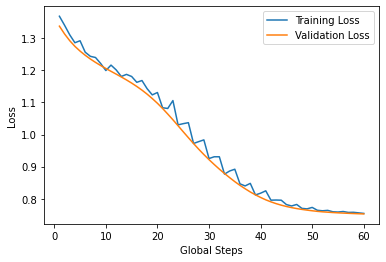

In [15]:
import matplotlib.pyplot as plt

train_loss_list, valid_loss_list, global_steps_list = load_metrics(destination_folder + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Training Loss')
plt.plot(global_steps_list, valid_loss_list, label='Validation Loss')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluating LSTM Model

In [16]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


# Evaluation Function
def evaluate(model, test_loader, threshold=0.5):
    y_pred = []
    y_true = []

    model.eval()
    with torch.no_grad():
        for (labels, (text, text_len)), _ in test_loader:           
            labels = labels.to(device)
            text = text.to(device)
            text_len = text_len.to(device)
            output = model(text, text_len)

            output = (output > threshold).int()
            y_pred.extend(output.tolist())
            y_true.extend(labels.tolist())
    
    y_pred = [np.argmax(y) for y in y_pred]
    print(y_pred)
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=np.unique(y_true), digits=4))
    
    cm = confusion_matrix(y_true, y_pred, np.unique(y_true))
    ax = plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(np.unique(y_true))
    ax.yaxis.set_ticklabels(np.unique(y_pred))


Model loaded from <== /content/drive/My Drive/AML_Project/model.pt
[0, 3, 0, 3, 0, 2, 2, 2, 2, 1, 1, 0, 1, 1, 3, 3, 3, 3, 1, 0, 3, 3, 3, 1, 2, 3, 1, 3, 3, 1, 3, 1, 0, 1, 3, 3, 3, 1, 2, 2, 2, 2, 2, 1, 1, 1, 1, 3, 3, 3, 2, 1, 1, 0, 1, 3, 0, 3, 3, 3, 3, 2, 2, 1, 1, 1, 1, 3, 3, 3, 1, 3, 3, 3, 0, 2, 0, 2, 1, 1, 1, 3, 0, 1, 1, 1, 1, 1, 3, 2, 2, 0, 3, 1, 3, 0, 3, 2, 2, 2, 1, 2, 2, 2, 2, 1, 1, 0, 2, 1, 1, 1, 1, 3, 3, 3, 3, 0, 0, 3, 3, 3, 1, 2, 1, 2, 1, 1, 3, 1, 0, 3, 3, 3, 1, 3, 3, 3, 2, 0, 2, 2, 2, 2, 2, 2, 2, 3, 3, 1, 1, 1, 1, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 1, 0, 2, 2, 2, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 1, 0, 3, 1, 1, 1, 1, 1, 0, 3, 3, 3, 3, 1, 0, 2, 1, 2, 2, 0, 2, 1, 3, 1, 3, 3, 1, 0, 1, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 3, 0, 1, 3, 3, 3, 0, 3, 3, 1, 1, 3, 3, 3, 2, 0, 2, 2, 0, 2, 2, 0, 1, 1, 3, 2, 2, 0, 3, 1, 1, 1, 3, 3, 1, 3, 3, 3, 0, 3, 3, 3, 3, 3, 0, 3, 2, 2, 2, 1, 2, 2, 2, 2, 2, 3, 3, 1, 3, 3, 3, 3, 3, 3, 2, 3, 1, 2, 2, 2, 2, 2, 1, 3, 1, 3, 1, 1, 3, 1, 2,

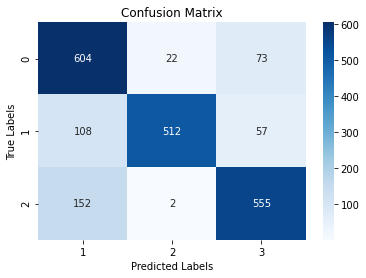

In [17]:
best_model = LSTM().to(device)
optimizer = optim.Adam(best_model.parameters(), lr=0.001)

load_checkpoint(destination_folder + '/model.pt', best_model, optimizer)
evaluate(best_model, test_iter)